# Condition Monitoring of Air Pressure Systems (APS) In Large Vehicles

## Executive Summary

## Introduction

In most countries, trucks and busses have the highest fatalities in proportion to the number of accident involvements. As such, there is growing pressure on trucking and bus companies to improve their safety measures. The most critical of these safety measures is the maintenance of the Air Pressure System (APS) which controls the braking and gear changes of large vehicles. In this notebook we will apply several machine learning techniques to classify the condition of an APS system to determine if it is at risk of failure.

## Considerations

1. There is an associated cost in performing the maintenance, as such we must also take into account the number of false positives in the result of the model.
2. Several approaches 

## Scope and Limitations

1. Variables used in the dataset are masked as it is proprietary data.

## Import Packages

In [1]:
import eif
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pickle as pkl
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from lightgbm import Dataset
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import random
from sklearn.metrics import precision_recall_curve
from scipy.stats import normaltest

## Define Functions

In [2]:
def apply_log(value):
    '''
    '''
    if np.isnan(value):
        return value
    else:
        return np.log1p(value)
    
def rescale(df):
    '''
    '''
    for col in df.columns:
        df[col] = df[col].apply(lambda x: apply_log(x))
    
    return df

def load_data(filename):
    '''
    '''
    df = pd.read_csv(filename)
    df = df.replace('na', np.nan)
    df = df.replace('neg', 0)
    df = df.replace('pos', 1)
    df = df.astype(float)
    print(df.shape)
    display(df.head())
    
    return df

def get_label(probability, thresh):
    '''
    '''
    if probability < thresh:
        return 0
    else:
        return 1
    
def eval_roc_auc(model, x, y, dataset):
    '''
    '''
    # Get scores
    y_pred = model.predict(x)
    auc = roc_auc_score(y, y_pred)
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    
    # Visualization of ROC
    fig, ax = plt.subplots(figsize=(5,5), dpi=120)
    ax.fill_between(fpr, tpr, alpha=0.4, label=f'Area = {auc}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve: {dataset}')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.grid()
    ax.text(0.5, 0.5, f'AUC: {np.round(auc,3)}', horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
    
def eval_prc(model, x, y, dataset, custom_thresh=None):
    '''
    '''
    # Get scores
    y_pred = model.predict(x)
    precision, recall, thresholds = precision_recall_curve(y, y_pred)
       
    f1s = []
    for thresh in range(0,100,1):
        y_pred_labels = list(map(lambda x: get_label(x, thresh/100), y_pred))
        f1s.append(f1_score(y_true=y, y_pred=y_pred_labels))
    
    if not custom_thresh:
        best_t = list(range(0,100,1))[f1s.index(max(f1s))]
        best_i = (abs(best_t/100 - np.array(thresholds))).argmin()
    else:
        best_t = custom_thresh
        best_i = (abs(best_t/100 - np.array(thresholds))).argmin()
    
    # Visualization of ROC
    fig, ax = plt.subplots(figsize=(5,5), dpi=120)
    ax.fill_between(recall, precision, alpha=0.4)
    ax.axvline(recall[best_i], color='red')
    ax.axhline(precision[best_i], color='red')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'PR Curve: {dataset}')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.grid()
    ax.text(0.5, 0.5, f'Max F1 Score: {np.round(max(f1s),3)}\nThreshold: {best_t/100}',
            horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)

## The Data

### Training Set

In [3]:
df_train = load_data('aps_failure_training_set.csv')

(60000, 171)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.0,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.0,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0.0,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


### Test Set

In [4]:
df_test = load_data('aps_failure_test_set.csv')

(16000, 171)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,60.0,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,0.0,82.0,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,0.0,66002.0,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,0.0,59816.0,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,0.0,1814.0,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


## Exploratory Data Analysis and Cleaning

### Class Label Distribution

The labels of the dataset is unbalanced, wherein there are only 1000 instances of near failures out of 60000 samples. We thus need to balance the dataset either through oversampling of the minority class or undersampling of the majority class. In addition, we can only use the AUC, F1, precision and recall to evaluate the performance of our model.

1000


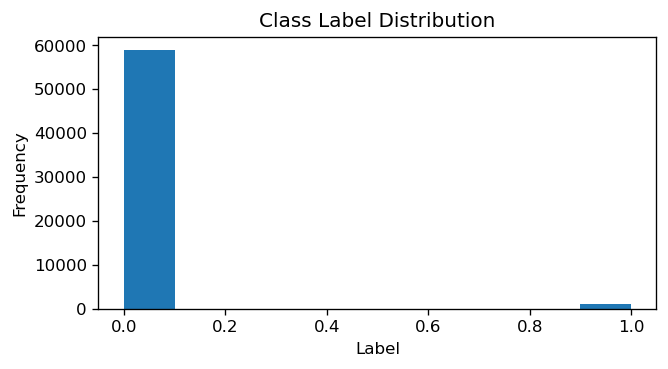

In [5]:
fig, ax = plt.subplots(figsize=(6,3), dpi=120)
df_train['class'].hist(ax=ax)
ax.set_title('Class Label Distribution')
ax.set_ylabel('Frequency')
ax.set_xlabel('Label')
ax.grid()
print(df_train[df_train['class']>0].shape[0])

### Null Handling

The data contains several null values, with some columns being comprised of more than 50% nulls. Since the variables are masked, there's no way for us to know what these variables mean, nor if there's any causality with the target variable. Imputing such a high percentage of unkown values is especially dangerous in the context of APS predictive maintenance.

Text(0.5, 0, 'Percentage')

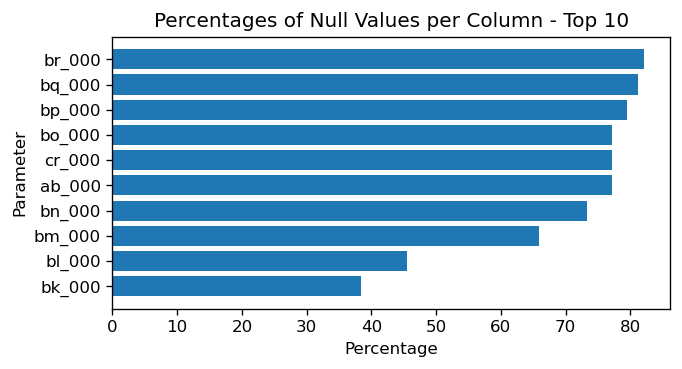

In [6]:
null_stats = (100*df_train.isnull().sum(axis=0)/df_train.shape[0]).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,3), dpi=120)
ax.barh(null_stats.iloc[-10:].index, null_stats.iloc[-10:])
ax.set_title('Percentages of Null Values per Column - Top 10')
ax.set_ylabel('Parameter')
ax.set_xlabel('Percentage')

However, if we were to drop rows / columns just because there are NaN values, we will be dropping a large chunk of our dataset.

In [7]:
print(df_train.dropna(how='any', axis=1).shape)
print(df_train.dropna(how='any').shape)

(60000, 2)
(591, 171)


It seems that the best course of action would be to drop rows / columns that exceed a certain threshold of null quantities. And then impute the values for the remaining cells. The code below shows the distribution of the null percentages along the rows and columns which will aid in identifying an appropriate threshold.

Text(0, 0.5, 'Frequency')

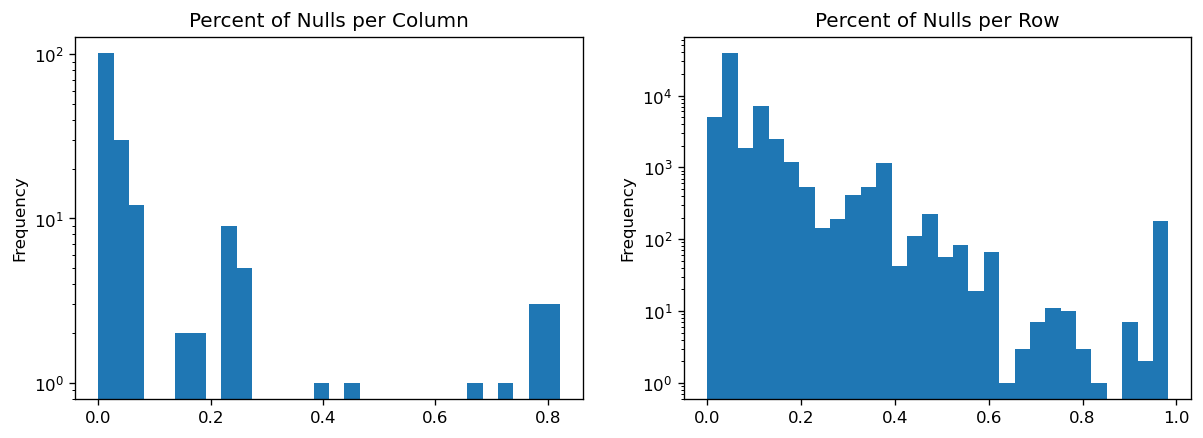

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=120)
(df_train.isnull().sum(axis=0)/df_train.shape[0]).hist(bins=30, ax=ax[0])
(df_train.isnull().sum(axis=1)/df_train.shape[1]).hist(bins=30, ax=ax[1])
ax[0].set_title('Percent of Nulls per Column')
ax[0].set_yscale('log')
ax[0].grid()
ax[0].set_ylabel('Frequency')
ax[1].set_title('Percent of Nulls per Row')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_ylabel('Frequency')

Columns and rows that contain more than 10% and 40% nulls respectively will be removed to reduce the amount of imputation needed. The end result is that we are left with `143` columns (inclusive of the target variable) along with `58329` (out of 59000) rows tagged as 0s and `995` (out of 1000) rows tagged as 1s.

In [9]:
df_cols3 = df_train.isnull().sum(axis=0)/df_train.shape[0]
df_cols3 = df_cols3[df_cols3<0.1]
len(df_cols3.index)

143

In [10]:
Counter(df_train[df_train[df_cols3.index].isnull().sum(axis=1)/df_train.shape[1]<0.40][df_cols3.index]['class'])

Counter({0.0: 58329, 1.0: 995})

In [11]:
df_train = df_train[df_train[df_cols3.index].isnull().sum(axis=1)/df_train.shape[1]<0.40][df_cols3.index]

### Check for Categorical or Continuous Variables

We must check if the variable is categorical or not so that we can apply the appropriate statistical tests. The code below counts the number of unique variables in a dataframe. The higher the count, the more likely it is to be a continuous variable. From here it seems that only `cd_0000` looks to be a categorical variable.

In [12]:
df_nunique = df_train.nunique(axis=0,
                              dropna=False).sort_values(ascending=True)
display(df_nunique.iloc[:10])

class      2
cd_000     2
as_000    21
ef_000    29
dz_000    48
eg_000    50
cs_009    53
au_000    57
ar_000    69
dj_000    73
dtype: int64

Checking `cd_0000` shows that it either has constant or a null value. We will drop this column from the modelling since it doesn't add any onformation due to it being a constant.

In [13]:
list(Counter(df_train['cd_000']).items())[:5]

[(1209600.0, 58842), (nan, 1), (nan, 1), (nan, 1), (nan, 1)]

In [14]:
df_train = df_train.drop('cd_000', axis=1)

### Check Distributions for Normality

Based on `D’Agostino’s K^2` test, it seems that none of our columns follow a normal distribution. This violates the assumption of `pearson's correlation test`. As such, we must use either `spearman's correlation test` or an ML approach with a built in feature importance (e.g. tree-based algorithms) to select which features to use.

In [15]:
normality = []
for col in df_train.columns:
    
    k2, p = normaltest(df_train[col], nan_policy='omit')
    alpha = 0.05
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        normality.append((col, 'not normal'))
    else:
        normality.append((col, 'normal'))
        
print(f'First 15 columns:\n{normality[:15]}')

First 15 columns:
[('class', 'not normal'), ('aa_000', 'not normal'), ('ac_000', 'not normal'), ('ae_000', 'not normal'), ('af_000', 'not normal'), ('ag_000', 'not normal'), ('ag_001', 'not normal'), ('ag_002', 'not normal'), ('ag_003', 'not normal'), ('ag_004', 'not normal'), ('ag_005', 'not normal'), ('ag_006', 'not normal'), ('ag_007', 'not normal'), ('ag_008', 'not normal'), ('ag_009', 'not normal')]


### Visualization on a Subset of Columns

Majority, of the distributions follow a power law distribution with some variables having exceedingly high values. To address this we will apply log-scaling since other scaling methods will result in a very skewed transformation.

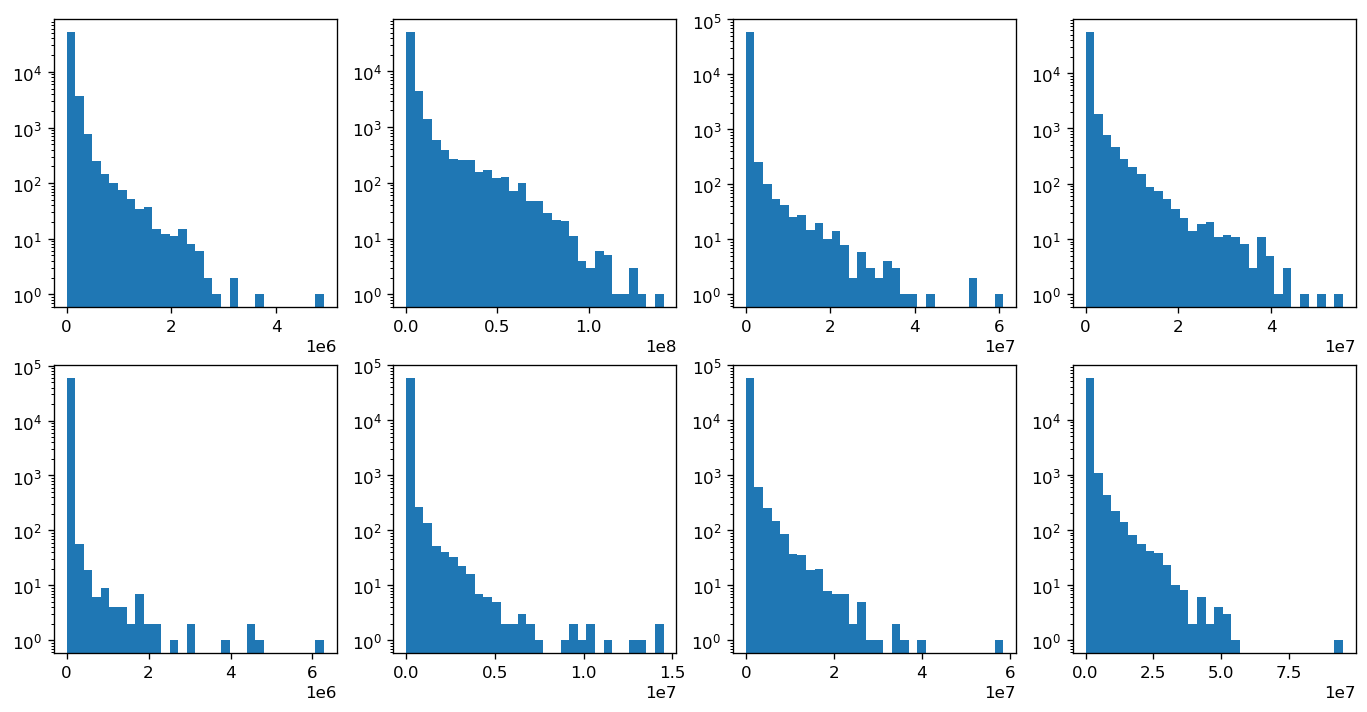

In [16]:
fig, ax = plt.subplots(2,4,figsize=(14,7), dpi=120)
for i, col in enumerate(df_train.columns[80:88]):
    if i < 4:
        j=0
    else:
        j=1
    df_train[col].hist(ax=ax[j][i%4], bins=30)
    ax[j][i%4].set_yscale('log')
    ax[j][i%4].grid()

## Rescaling the Data

The code below executes the log scaling on the features. This is because we have variables that are very large (in the 1000s) that do not have a normal distribution. Log-scaling the data will make it such that the distribution is retained but the value will be smaller. This will greatly help in reducing the scale of the computations for our model. Note that the code below will ignore null values in the transformation.

In [17]:
x = df_train[df_train.columns[1:]]
x = rescale(x)
y = df_train['class']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Imputing Null Values

Since most of the dataset follows a power law distribution, we will impute the missing values using the mode.

In [18]:
imputer = SimpleImputer(strategy='most_frequent')
x = imputer.fit_transform(x)

## Outlier Analysis

Model performance can be negatively affected by outlying data points. As such it may be useful to analyze the outliers in the data set prior to modelling. Since the data is high dimensional (142 features) we will use an ML approach to checking for outliers.

Our chosen Outlier Detection approach is via the Extended Isolation Forest (EIF) algorithm (an improvement over Isolation Forest (IF)) which bisects the hyperplanes in multiple dimensions at each iteration. The idea of EIF is the same as IF wherein a datapoint's anomaly score is higher if it can be easily isolated from the rest of the datapoints. EIF solves the issues of imaginary dense clusters forming up in areas of low density. For more details on EIF you can check this paper: https://arxiv.org/pdf/1811.02141.pdf

A `sample_size` of 5000 was chosen to ensure that the distribution is somewhat preserved. The `number of tree estimators` was set to 125 to ensure that multiple subset of features will be explored by the model. Finally, an `ExtensionLevel` of 71 was chosen such that the model is bisecting the hyperplane 71 dimensions at a time (1/2 of all dimensions). Adding more extension levels does not necessarily improve performance, but it would certainly increase the computational complexity. By intersecting only half of all dimensions it gives the model some degree of freedom.

In [ ]:
eif_71 = eif.iForest(X, ntrees=125, sample_size=5000, ExtensionLevel=71)
anomaly_scores_71 = eif_71.compute_paths(X_in=X)

In [19]:
# with open('anomaly_scores_71.pkl', 'wb') as f:
#     pkl.dump(anomaly_scores_71, f)
    
with open('anomaly_scores_71.pkl','rb') as f:
    anomaly_scores_71 = pkl.load(f)

The frequency distribution of the anomaly scores can be seen below wherein the higher the score the more anomalous the datapoint is. The distribution is positively skewed. Most of the data points have an anomaly score around 0.40.

Text(0.5, 0, 'Anomaly Score')

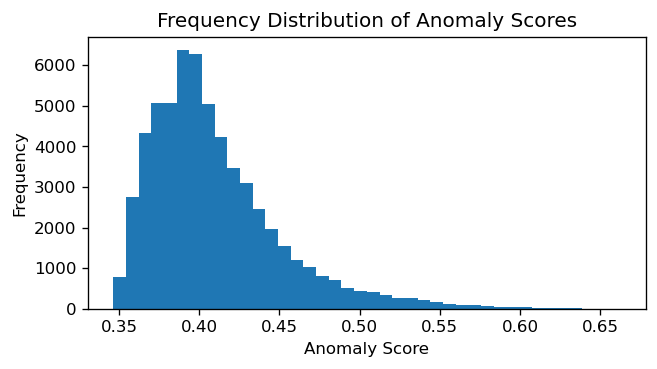

In [20]:
fig, ax = plt.subplots(figsize=(6,3), dpi=120)
ax.hist(anomaly_scores_71, bins=40)
ax.set_title('Frequency Distribution of Anomaly Scores')
ax.set_ylabel('Frequency')
ax.set_xlabel('Anomaly Score')

The code below extracts all the data points that go beyond an arbitrary outlier threshold that we define. **And it turns out that a good portion of our failure events are outlier cases. Infact, just by setting the threshold to 0.45, we are already able to capture 90% of the outlier cases.** In hindsight, this is expected because failure events are supposed to be outliers! If not then the manufactured product (APS) would be downright unreliable.

In [21]:
Counter(y.values[np.where(anomaly_scores_71 > 0.413)])

Counter({0.0: 20793, 1.0: 965})

While EIF is able to capture a lot of the failure events, we also run the risk of having too many false positives. **If we are to use this model as it is, then more than 10% of our negative cases will be flagged.** This is because we have yet to determine which of these variables are actually relevant in identifying APS failures. A high anomaly score doesn't necessarily mean that it is a failure event, because the outlying feature may not even be related to the APS failure to begin with! **Feature importance is valuable information in the context of condition monitoring as it provides us insights into the failure signatures which we can then use to improve the product.**

## Modelling and Feature Importance

The usecase is an unbalanced binary classification problem wherein three approaches are possible:
1. Oversampling the minority class.
2. Undersampling the majority class.
3. Using a training function designed for imbalanced cases.
4. A hybrid approach of any of the above 3 cases.

For the initial model we chose the hybrid approach wehrein we also considered the outlying nature of the failures. We hypothesized that we could undersample the majority class by selecting only the outlying cases. Afterwhich we could perform unbalanced classification to sort out the failure events from the non-failure events (i.e. classification of outliers). This approach leverages on the fact that inlying datapoints are all non-failure events. Through this approach, the question now becomes: from all my outlying events, which of these are APS failures and what are its failure signatures.

### Training Set Preparation

Since our failure signatures are outliers, we will approach this problem by trying to classify which outliers are actually valid failures. The code below focuses on the data points that have an anomaly score that is more than 0.413. This threshold was chosen as majority of our failure events have already been captured by then.

In [22]:
# Remove inlying majority class
df_tmp = pd.DataFrame(anomaly_scores_71,
                      columns=['anomaly_score']).join(pd.DataFrame(y.reset_index(drop=True))
                                                      .join(pd.DataFrame(x)))

x_2_0 = df_tmp[(df_tmp['anomaly_score']>0.413)&(df_tmp['class']==0.0)]
x_2_0 = x_2_0[x_2_0.columns[1:]]
x_2_1 = df_tmp[df_tmp['class']==1.0]
x_2_1 = x_2_1[x_2_1.columns[1:]]

# Append then shuffle the data
data_2 = x_2_0.append(x_2_1).sample(frac=1)
x_2 = data_2[data_2.columns[1:]]
y_2 = data_2['class']

# # Balance the dataset using SMOTE
# sm = SMOTE(random_state=42, n_jobs=-1)
# x_res2, y_res2 = sm.fit_resample(x_2, y_2)

### Test Set Preparation

We will not drop outliers in the test set, this is done to check if the model will also be able to classify the inliers appropriately.

In [43]:
x_test = df_test[df_train.columns[1:]]
# No droping of rows with many null values

x_test = rescale(x_test)

imputer = SimpleImputer(strategy='most_frequent')
x_test = imputer.fit_transform(x_test)

x_test = pd.DataFrame(x_test)
x_test.columns = x_2.columns

# No outlier analysis / inlier removal
y_test = df_test['class']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Hyperparameter Tuning

The code below executes hyperparameter tuning on the LGBM model. The training set has around 22k rows, 10 folds was used to ensure that the chosen hyperparameters are not overfitting. The cross validation metric is AUC to account for the unbalanced nature of the dataset. The maximum average AUC across across each hyperparameter will be used to train the final model.

In [ ]:
param_grid = {'num_leaves': [70,50,30],
              'min_data_in_leaf': [35,55,75],
              'lambda_l1': [0.00001,0.0001,0.001],
              'lambda_l2': [10,100,1000],
              'bagging_fraction':[0.5],
              'feature_fraction':[0.5],
              'objective':['binary'],'path_smooth':[3],
              'max_depth':[10], 'max_bin':[150],
              'min_gain_to_split':[0.2],
              'learning_rate':[0.1]}

len(list(ParameterGrid(param_grid)))

In [272]:
cv_results = []
for i,hyperparams in enumerate(list(ParameterGrid(param_grid))):
    
    validation_summary = lgb.cv(hyperparams,
                                Dataset(x_2, label=y_2),
                                num_boost_round=1500,
                                nfold=10,
                                metrics=["auc"],
                                early_stopping_rounds=25,
                                verbose_eval=25, seed=42)
    
    # Store the best hyperparameters
    cv_results.append((hyperparams, validation_summary["auc-mean"][-1]))
    
    print(i)

[25]	cv_agg's auc: 0.980956 + 0.00762579
[50]	cv_agg's auc: 0.98241 + 0.00891101
[75]	cv_agg's auc: 0.983465 + 0.00913202
[100]	cv_agg's auc: 0.984203 + 0.00910271
[125]	cv_agg's auc: 0.984454 + 0.00912588
[150]	cv_agg's auc: 0.984401 + 0.00931032
0
[25]	cv_agg's auc: 0.980935 + 0.00775844
[50]	cv_agg's auc: 0.982694 + 0.00869713
[75]	cv_agg's auc: 0.98349 + 0.00919205
1
[25]	cv_agg's auc: 0.98068 + 0.0074834
[50]	cv_agg's auc: 0.982894 + 0.00839021
[75]	cv_agg's auc: 0.984274 + 0.00804628
[100]	cv_agg's auc: 0.984735 + 0.00824786
[125]	cv_agg's auc: 0.984954 + 0.0082732
[150]	cv_agg's auc: 0.984856 + 0.00853469
2
[25]	cv_agg's auc: 0.980001 + 0.00822228
[50]	cv_agg's auc: 0.982419 + 0.00877668
[75]	cv_agg's auc: 0.983606 + 0.00902905
[100]	cv_agg's auc: 0.984026 + 0.00900319
[125]	cv_agg's auc: 0.984223 + 0.00902865
3
[25]	cv_agg's auc: 0.980001 + 0.00822228
[50]	cv_agg's auc: 0.982585 + 0.00866007
[75]	cv_agg's auc: 0.9841 + 0.00824606
[100]	cv_agg's auc: 0.984334 + 0.00839326
[125]	

[475]	cv_agg's auc: 0.979029 + 0.0085477
[500]	cv_agg's auc: 0.979237 + 0.00846621
[525]	cv_agg's auc: 0.979495 + 0.00836058
[550]	cv_agg's auc: 0.979719 + 0.00827398
[575]	cv_agg's auc: 0.979936 + 0.0081997
[600]	cv_agg's auc: 0.980098 + 0.00810489
[625]	cv_agg's auc: 0.980251 + 0.00804475
[650]	cv_agg's auc: 0.980389 + 0.0080152
[675]	cv_agg's auc: 0.98049 + 0.00795327
[700]	cv_agg's auc: 0.98058 + 0.00793548
[725]	cv_agg's auc: 0.980674 + 0.00793204
[750]	cv_agg's auc: 0.980752 + 0.00791111
[775]	cv_agg's auc: 0.980844 + 0.00785899
[800]	cv_agg's auc: 0.980941 + 0.00782525
[825]	cv_agg's auc: 0.981038 + 0.00782273
[850]	cv_agg's auc: 0.981101 + 0.00779828
[875]	cv_agg's auc: 0.981181 + 0.00776169
[900]	cv_agg's auc: 0.981268 + 0.00771985
[925]	cv_agg's auc: 0.981322 + 0.00770167
[950]	cv_agg's auc: 0.981389 + 0.00767476
[975]	cv_agg's auc: 0.981446 + 0.00761763
[1000]	cv_agg's auc: 0.981506 + 0.00761153
[1025]	cv_agg's auc: 0.981551 + 0.00758857
[1050]	cv_agg's auc: 0.981571 + 0.007

[850]	cv_agg's auc: 0.981072 + 0.00772842
[875]	cv_agg's auc: 0.981125 + 0.00770103
[900]	cv_agg's auc: 0.981186 + 0.00769591
[925]	cv_agg's auc: 0.981254 + 0.00768148
[950]	cv_agg's auc: 0.981297 + 0.00769094
[975]	cv_agg's auc: 0.981357 + 0.00765407
[1000]	cv_agg's auc: 0.981395 + 0.00764494
[1025]	cv_agg's auc: 0.981413 + 0.00764783
[1050]	cv_agg's auc: 0.981477 + 0.0076444
[1075]	cv_agg's auc: 0.981509 + 0.00762403
[1100]	cv_agg's auc: 0.981542 + 0.00763191
[1125]	cv_agg's auc: 0.981567 + 0.00762862
[1150]	cv_agg's auc: 0.981608 + 0.00762708
[1175]	cv_agg's auc: 0.981641 + 0.00760766
[1200]	cv_agg's auc: 0.981682 + 0.00761546
[1225]	cv_agg's auc: 0.981709 + 0.00759756
[1250]	cv_agg's auc: 0.981724 + 0.00760539
[1275]	cv_agg's auc: 0.981744 + 0.00760127
[1300]	cv_agg's auc: 0.981774 + 0.00759514
[1325]	cv_agg's auc: 0.981796 + 0.00759643
[1350]	cv_agg's auc: 0.981801 + 0.00760356
[1375]	cv_agg's auc: 0.98183 + 0.00759898
[1400]	cv_agg's auc: 0.981857 + 0.00760232
[1425]	cv_agg's auc

[1225]	cv_agg's auc: 0.981542 + 0.00784663
[1250]	cv_agg's auc: 0.981582 + 0.00784421
[1275]	cv_agg's auc: 0.981614 + 0.00782517
[1300]	cv_agg's auc: 0.981673 + 0.00778739
[1325]	cv_agg's auc: 0.981723 + 0.00776561
[1350]	cv_agg's auc: 0.981743 + 0.00778922
[1375]	cv_agg's auc: 0.981739 + 0.00781154
24
[25]	cv_agg's auc: 0.950331 + 0.00799008
[50]	cv_agg's auc: 0.962589 + 0.00866385
[75]	cv_agg's auc: 0.966831 + 0.00819158
[100]	cv_agg's auc: 0.969669 + 0.00853328
[125]	cv_agg's auc: 0.971065 + 0.00882933
[150]	cv_agg's auc: 0.972106 + 0.00912581
[175]	cv_agg's auc: 0.973063 + 0.00930159
[200]	cv_agg's auc: 0.97418 + 0.0092814
[225]	cv_agg's auc: 0.97485 + 0.0093761
[250]	cv_agg's auc: 0.975541 + 0.00937991
[275]	cv_agg's auc: 0.976179 + 0.00928465
[300]	cv_agg's auc: 0.976734 + 0.00916121
[325]	cv_agg's auc: 0.977173 + 0.00907772
[350]	cv_agg's auc: 0.977488 + 0.00900053
[375]	cv_agg's auc: 0.977761 + 0.00891802
[400]	cv_agg's auc: 0.97801 + 0.00887639
[425]	cv_agg's auc: 0.978294 + 0

37
[25]	cv_agg's auc: 0.973425 + 0.00790831
[50]	cv_agg's auc: 0.977596 + 0.00833666
[75]	cv_agg's auc: 0.979487 + 0.00884823
[100]	cv_agg's auc: 0.98122 + 0.00836066
[125]	cv_agg's auc: 0.982052 + 0.0083749
[150]	cv_agg's auc: 0.982826 + 0.00808799
[175]	cv_agg's auc: 0.983211 + 0.00811511
[200]	cv_agg's auc: 0.983456 + 0.00816385
[225]	cv_agg's auc: 0.983641 + 0.00814727
[250]	cv_agg's auc: 0.983918 + 0.00809804
[275]	cv_agg's auc: 0.984036 + 0.00809768
[300]	cv_agg's auc: 0.984114 + 0.00812011
[325]	cv_agg's auc: 0.984276 + 0.00807859
[350]	cv_agg's auc: 0.984312 + 0.00803089
[375]	cv_agg's auc: 0.984337 + 0.00800569
[400]	cv_agg's auc: 0.984383 + 0.00796574
[425]	cv_agg's auc: 0.984404 + 0.0080433
38
[25]	cv_agg's auc: 0.972965 + 0.00817635
[50]	cv_agg's auc: 0.977536 + 0.00847784
[75]	cv_agg's auc: 0.979779 + 0.00845508
[100]	cv_agg's auc: 0.981114 + 0.00844913
[125]	cv_agg's auc: 0.981872 + 0.00839347
[150]	cv_agg's auc: 0.982396 + 0.00855459
[175]	cv_agg's auc: 0.982836 + 0.0084

[850]	cv_agg's auc: 0.981101 + 0.00779828
[875]	cv_agg's auc: 0.981184 + 0.00776552
[900]	cv_agg's auc: 0.981264 + 0.00771601
[925]	cv_agg's auc: 0.981323 + 0.00770277
[950]	cv_agg's auc: 0.981388 + 0.00767311
[975]	cv_agg's auc: 0.981448 + 0.00761982
[1000]	cv_agg's auc: 0.981501 + 0.00760608
[1025]	cv_agg's auc: 0.981545 + 0.00758207
[1050]	cv_agg's auc: 0.981567 + 0.00759098
[1075]	cv_agg's auc: 0.981604 + 0.00759363
[1100]	cv_agg's auc: 0.981628 + 0.00759532
[1125]	cv_agg's auc: 0.981646 + 0.00760331
[1150]	cv_agg's auc: 0.981695 + 0.00759932
[1175]	cv_agg's auc: 0.981735 + 0.00759163
[1200]	cv_agg's auc: 0.981757 + 0.00757813
[1225]	cv_agg's auc: 0.981798 + 0.00757481
[1250]	cv_agg's auc: 0.981813 + 0.00756867
[1275]	cv_agg's auc: 0.981835 + 0.00757314
[1300]	cv_agg's auc: 0.981855 + 0.00756635
[1325]	cv_agg's auc: 0.981879 + 0.00756688
[1350]	cv_agg's auc: 0.981907 + 0.00755598
[1375]	cv_agg's auc: 0.981929 + 0.00755849
[1400]	cv_agg's auc: 0.981944 + 0.00756325
[1425]	cv_agg's a

[1250]	cv_agg's auc: 0.981742 + 0.00758959
[1275]	cv_agg's auc: 0.981745 + 0.00760162
[1300]	cv_agg's auc: 0.981762 + 0.00761053
[1325]	cv_agg's auc: 0.981777 + 0.00762979
[1350]	cv_agg's auc: 0.981788 + 0.00763072
[1375]	cv_agg's auc: 0.981817 + 0.00762324
[1400]	cv_agg's auc: 0.981845 + 0.00760586
[1425]	cv_agg's auc: 0.981856 + 0.0076221
[1450]	cv_agg's auc: 0.98188 + 0.00762275
[1475]	cv_agg's auc: 0.981876 + 0.00762918
[1500]	cv_agg's auc: 0.981897 + 0.00762879
49
[25]	cv_agg's auc: 0.950297 + 0.00724833
[50]	cv_agg's auc: 0.962448 + 0.00823218
[75]	cv_agg's auc: 0.966537 + 0.00839763
[100]	cv_agg's auc: 0.969694 + 0.0084749
[125]	cv_agg's auc: 0.971507 + 0.00848892
[150]	cv_agg's auc: 0.973034 + 0.00828765
[175]	cv_agg's auc: 0.973746 + 0.00854538
[200]	cv_agg's auc: 0.974377 + 0.00895104
[225]	cv_agg's auc: 0.975017 + 0.00909841
[250]	cv_agg's auc: 0.975678 + 0.00911023
[275]	cv_agg's auc: 0.976225 + 0.00912327
[300]	cv_agg's auc: 0.976756 + 0.00901541
[325]	cv_agg's auc: 0.9773

[375]	cv_agg's auc: 0.977761 + 0.00891802
[400]	cv_agg's auc: 0.97801 + 0.00887639
[425]	cv_agg's auc: 0.978294 + 0.00880459
[450]	cv_agg's auc: 0.97855 + 0.00870159
[475]	cv_agg's auc: 0.97875 + 0.00866889
[500]	cv_agg's auc: 0.978987 + 0.00858071
[525]	cv_agg's auc: 0.979217 + 0.00851372
[550]	cv_agg's auc: 0.979439 + 0.00843815
[575]	cv_agg's auc: 0.979591 + 0.00840897
[600]	cv_agg's auc: 0.979776 + 0.0083649
[625]	cv_agg's auc: 0.979894 + 0.00829591
[650]	cv_agg's auc: 0.979996 + 0.0082718
[675]	cv_agg's auc: 0.980132 + 0.00824066
[700]	cv_agg's auc: 0.980237 + 0.00818621
[725]	cv_agg's auc: 0.980373 + 0.00815266
[750]	cv_agg's auc: 0.980475 + 0.0081313
[775]	cv_agg's auc: 0.980583 + 0.00811337
[800]	cv_agg's auc: 0.980655 + 0.00808796
[825]	cv_agg's auc: 0.980715 + 0.00807663
[850]	cv_agg's auc: 0.980791 + 0.008064
[875]	cv_agg's auc: 0.980869 + 0.00803633
[900]	cv_agg's auc: 0.980917 + 0.00803165
[925]	cv_agg's auc: 0.98098 + 0.00801266
[950]	cv_agg's auc: 0.981025 + 0.00800635
[

[300]	cv_agg's auc: 0.983693 + 0.0081786
[325]	cv_agg's auc: 0.983768 + 0.0082304
[350]	cv_agg's auc: 0.983801 + 0.00814123
[375]	cv_agg's auc: 0.983962 + 0.00805194
[400]	cv_agg's auc: 0.984024 + 0.00805584
69
[25]	cv_agg's auc: 0.971797 + 0.00799038
[50]	cv_agg's auc: 0.976988 + 0.00926886
[75]	cv_agg's auc: 0.978732 + 0.00940309
[100]	cv_agg's auc: 0.980326 + 0.00915974
[125]	cv_agg's auc: 0.981283 + 0.0089291
[150]	cv_agg's auc: 0.982021 + 0.00872634
[175]	cv_agg's auc: 0.982598 + 0.0085199
[200]	cv_agg's auc: 0.982977 + 0.00835111
[225]	cv_agg's auc: 0.98329 + 0.00828283
[250]	cv_agg's auc: 0.983466 + 0.00828163
[275]	cv_agg's auc: 0.983583 + 0.0082373
[300]	cv_agg's auc: 0.983693 + 0.0081786
[325]	cv_agg's auc: 0.983768 + 0.0082304
[350]	cv_agg's auc: 0.983801 + 0.00814123
[375]	cv_agg's auc: 0.983962 + 0.00805194
[400]	cv_agg's auc: 0.984024 + 0.00805584
70
[25]	cv_agg's auc: 0.971797 + 0.00799038
[50]	cv_agg's auc: 0.976989 + 0.00926968
[75]	cv_agg's auc: 0.978751 + 0.009419
[1

[1075]	cv_agg's auc: 0.981554 + 0.0076299
[1100]	cv_agg's auc: 0.981574 + 0.00764849
[1125]	cv_agg's auc: 0.981598 + 0.00765987
[1150]	cv_agg's auc: 0.981656 + 0.0076469
[1175]	cv_agg's auc: 0.981693 + 0.00764206
[1200]	cv_agg's auc: 0.981713 + 0.00764067
[1225]	cv_agg's auc: 0.981727 + 0.00763363
[1250]	cv_agg's auc: 0.981754 + 0.00763212
[1275]	cv_agg's auc: 0.981777 + 0.00762807
[1300]	cv_agg's auc: 0.981813 + 0.00761737
[1325]	cv_agg's auc: 0.981833 + 0.00761201
[1350]	cv_agg's auc: 0.981852 + 0.0076053
[1375]	cv_agg's auc: 0.981872 + 0.00762308
[1400]	cv_agg's auc: 0.981893 + 0.00763015
[1425]	cv_agg's auc: 0.981906 + 0.00762321
[1450]	cv_agg's auc: 0.98192 + 0.00762358
[1475]	cv_agg's auc: 0.981946 + 0.00762465
[1500]	cv_agg's auc: 0.981953 + 0.00762608
74
[25]	cv_agg's auc: 0.950297 + 0.00724833
[50]	cv_agg's auc: 0.962448 + 0.00823218
[75]	cv_agg's auc: 0.966536 + 0.00839829
[100]	cv_agg's auc: 0.969694 + 0.0084749
[125]	cv_agg's auc: 0.971507 + 0.00848892
[150]	cv_agg's auc: 0

[1450]	cv_agg's auc: 0.981974 + 0.00748823
[1475]	cv_agg's auc: 0.98199 + 0.0074965
[1500]	cv_agg's auc: 0.981986 + 0.00750736
77
[25]	cv_agg's auc: 0.950331 + 0.00799008
[50]	cv_agg's auc: 0.962589 + 0.00866385
[75]	cv_agg's auc: 0.966831 + 0.00819158
[100]	cv_agg's auc: 0.969669 + 0.00853328
[125]	cv_agg's auc: 0.971065 + 0.00882933
[150]	cv_agg's auc: 0.972106 + 0.00912581
[175]	cv_agg's auc: 0.973063 + 0.00930159
[200]	cv_agg's auc: 0.97418 + 0.0092814
[225]	cv_agg's auc: 0.97485 + 0.0093761
[250]	cv_agg's auc: 0.975539 + 0.00937905
[275]	cv_agg's auc: 0.976181 + 0.00928554
[300]	cv_agg's auc: 0.976698 + 0.00922444
[325]	cv_agg's auc: 0.977187 + 0.00906852
[350]	cv_agg's auc: 0.977468 + 0.0090383
[375]	cv_agg's auc: 0.977767 + 0.00894381
[400]	cv_agg's auc: 0.978015 + 0.00888043
[425]	cv_agg's auc: 0.978302 + 0.00879066
[450]	cv_agg's auc: 0.978553 + 0.008694
[475]	cv_agg's auc: 0.978759 + 0.00866142
[500]	cv_agg's auc: 0.978939 + 0.0086228
[525]	cv_agg's auc: 0.979137 + 0.00858908

Once the best hyperparameters are chosen, we will now train the final model using the best performing hyperparameters.

In [24]:
# with open('cv.pkl', 'wb') as f:
#     pkl.dump(sorted(cv_results, key=lambda x: x[1], reverse=True), f)
with open('cv.pkl', 'rb') as f:
    cv_results = pkl.load(f)

In [25]:
params = cv_results[0][0]
params['metric'] = ["auc"]
params['num_boost_round'] = 1500
params['nfold'] = 10
params['early_stopping_rounds'] = 25
params['verbose_eval'] = 25

The training set will be divided into 4 parts. The first part will be used to train the model, while the 3 other parts will serve to validate the model to ensure that the resulting performance is not just due to the random split. Three validation sets were used to ensure that it is not overfitting. The final model outputs a score (probability) that tells you the likelihood that the data poit is a failure event.

In [27]:
# Split Use 3 Validation Sets From Training Set
train_index = random.sample(range(x_2.shape[0]), 10000)
val_index = list(set(range(x_2.shape[0])).difference(train_index))
random.shuffle(val_index)
validation_sets = [Dataset(x_2.values[val_index[x::3]],
                           label=y_2.values[val_index[x::3]])
                   for x in range(3)]

# Model
lgbm_model = lgb.train(params, Dataset(x_2.values[train_index],
                                       label=y_2.values[train_index]),
                       valid_sets=validation_sets)

[1]	valid_0's auc: 0.948866	valid_1's auc: 0.926676	valid_2's auc: 0.944161
Training until validation scores don't improve for 25 rounds
[2]	valid_0's auc: 0.966342	valid_1's auc: 0.942785	valid_2's auc: 0.958471
[3]	valid_0's auc: 0.970706	valid_1's auc: 0.947581	valid_2's auc: 0.963073
[4]	valid_0's auc: 0.974149	valid_1's auc: 0.953748	valid_2's auc: 0.963825
[5]	valid_0's auc: 0.974773	valid_1's auc: 0.954456	valid_2's auc: 0.964928
[6]	valid_0's auc: 0.976104	valid_1's auc: 0.955985	valid_2's auc: 0.968278
[7]	valid_0's auc: 0.976357	valid_1's auc: 0.95666	valid_2's auc: 0.968405
[8]	valid_0's auc: 0.976717	valid_1's auc: 0.959351	valid_2's auc: 0.969119
[9]	valid_0's auc: 0.977032	valid_1's auc: 0.960139	valid_2's auc: 0.96939
[10]	valid_0's auc: 0.977547	valid_1's auc: 0.96071	valid_2's auc: 0.969452
[11]	valid_0's auc: 0.979733	valid_1's auc: 0.963183	valid_2's auc: 0.969482
[12]	valid_0's auc: 0.980402	valid_1's auc: 0.964413	valid_2's auc: 0.969938
[13]	valid_0's auc: 0.98092

[128]	valid_0's auc: 0.985184	valid_1's auc: 0.972715	valid_2's auc: 0.984949
[129]	valid_0's auc: 0.985068	valid_1's auc: 0.972754	valid_2's auc: 0.984985
[130]	valid_0's auc: 0.985029	valid_1's auc: 0.972782	valid_2's auc: 0.985029
[131]	valid_0's auc: 0.985057	valid_1's auc: 0.972813	valid_2's auc: 0.985098
[132]	valid_0's auc: 0.985079	valid_1's auc: 0.972915	valid_2's auc: 0.985071
[133]	valid_0's auc: 0.985144	valid_1's auc: 0.972824	valid_2's auc: 0.98505
[134]	valid_0's auc: 0.985157	valid_1's auc: 0.972754	valid_2's auc: 0.985112
[135]	valid_0's auc: 0.985097	valid_1's auc: 0.972619	valid_2's auc: 0.985112
[136]	valid_0's auc: 0.985037	valid_1's auc: 0.972642	valid_2's auc: 0.985125
[137]	valid_0's auc: 0.984985	valid_1's auc: 0.972686	valid_2's auc: 0.985086
Early stopping, best iteration is:
[112]	valid_0's auc: 0.985284	valid_1's auc: 0.972922	valid_2's auc: 0.984622


## Validation

We will evaluate the model using ROC-AUC, PR Curve and F1 score. The associated cost for a False Positive is 10, whereas the associated cost for a False Negative is 500. Recall that a positive label (1) in this case means that the APS system is failing. An optimal threshold will be determined via a custom made function.

### ROC-AUC Score

The plots below shows relationship between the True Positive Rate and the False Positive rate across different threshold values of the binary classification. The overall performance of the model is measured by the area under the curve which is indepedent of the threshold.

#### Training Set

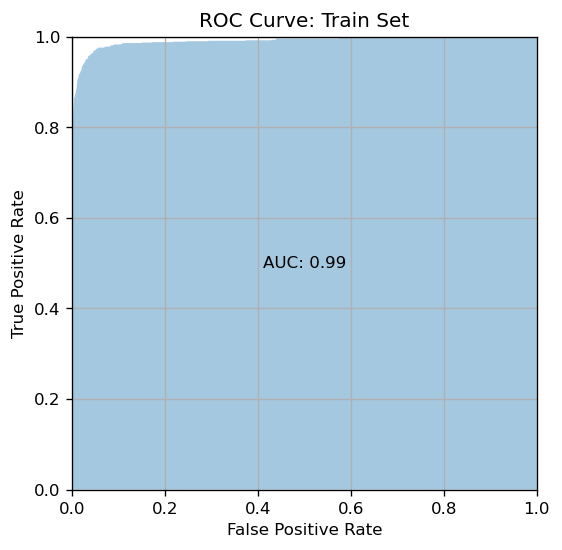

In [28]:
eval_roc_auc(lgbm_model, x_2, y_2, 'Train Set')

#### Test Set

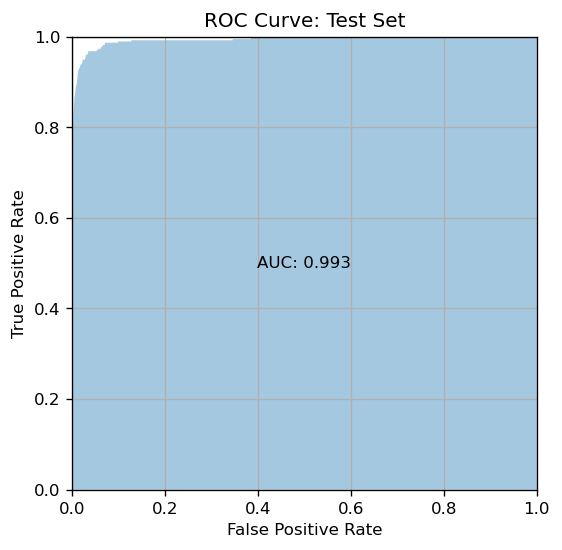

In [29]:
eval_roc_auc(lgbm_model, x_test, y_test, 'Test Set')

### PR Curve - Maximum Fbeta Score

The PR Curve is similar to ROC but this time we are interested in the `Precision` and `Recall`. `Precision` measures how much of the predicted failure events are actually failure events, whereas `Recall` measures how much of the failure events were actually captured. The maximum F1 score is also computed under the assumption that the `Precision` and `Recall` have equal importance (equal cost).

#### Train Set

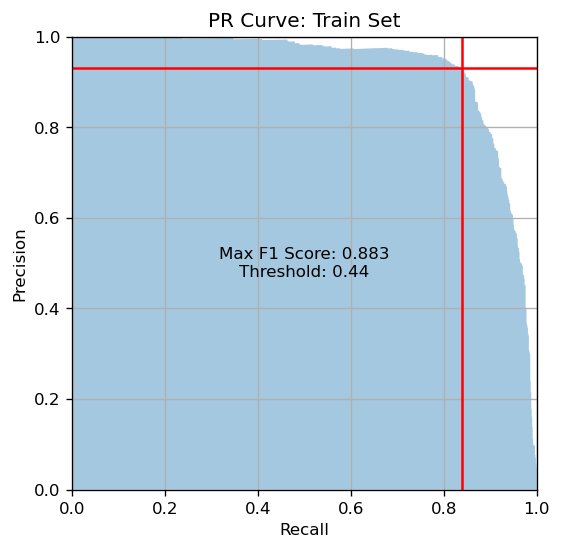

In [30]:
eval_prc(lgbm_model, x_2, y_2, 'Train Set')

#### Test Set

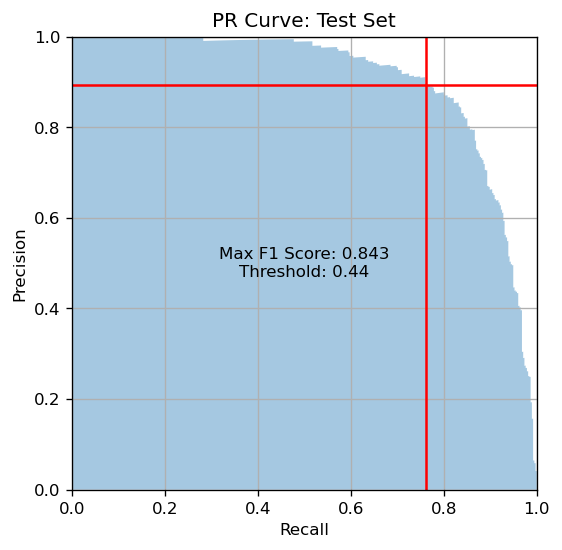

In [31]:
eval_prc(lgbm_model, x_test, y_test, 'Test Set', 44)

The model seems to be performing well for both ROC-AUC and PR-F1 measures. We can now proceed to feature importance to check which variables are useful for modelling the target variable.

## Feature Importance

We will rely on SHAP to explain the performance of our LGBM model. The code below highlights the top 20 most relevant features based on their SHAP value. The color of the points gives a hint at the value of each variable (high or low). Note that we will still need to view the actual distribution to get a better understanding of the system's behavior.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


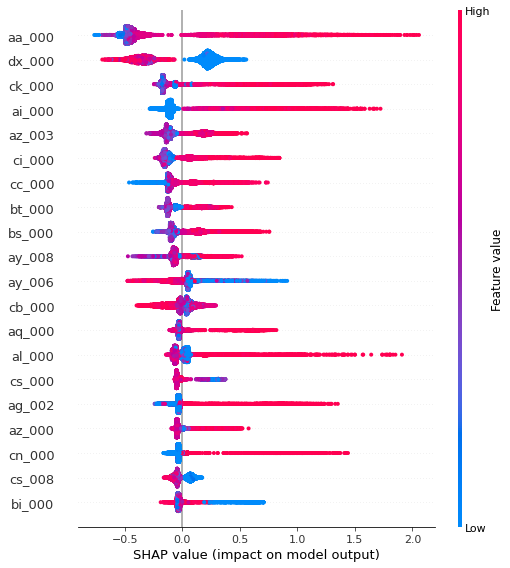

In [32]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(x_2)

df_x2 = pd.DataFrame(x_2)
df_x2.columns=df_train.columns[1:]

shap.summary_plot(shap_values[1], df_x2)

### SHAP Value Distribution per Predictor

The code below shows the distribution of the SHAP value versus the top 20 most relevant features. It can clearly be seen that above a certain point the SHAP value suddenly rises / falls. This is a common phenomenon in failure analysis, wherein a device functions normally but suddenly breaksdown when a parameter (e.g. temperature, pressure) goes above or below a certain point. It is highly likely that some of the False Positives are simply points that are very near the breakdown point.

**Unfortunately, we won't be able to do a deep dive on the features since they've been masked since they're proprietary information.**

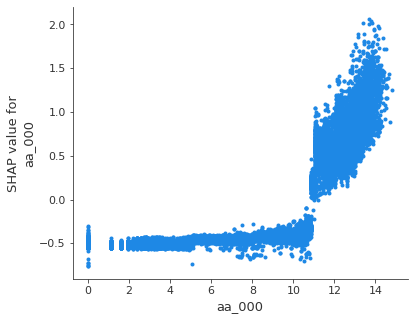

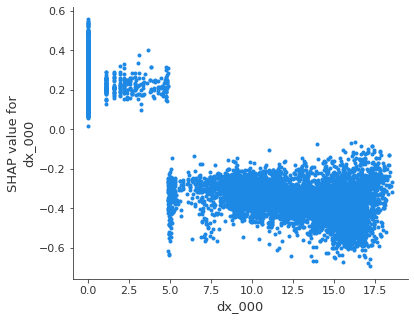

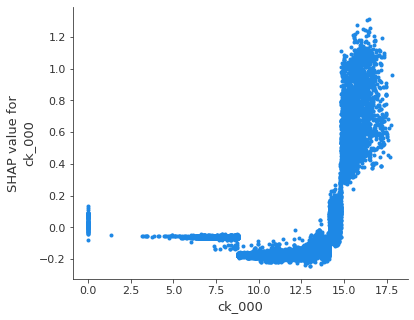

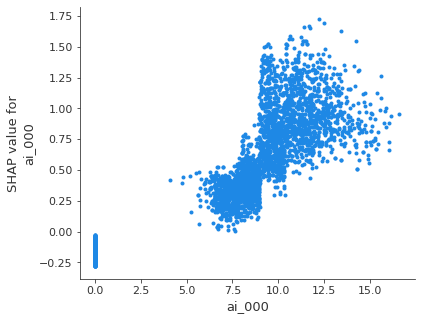

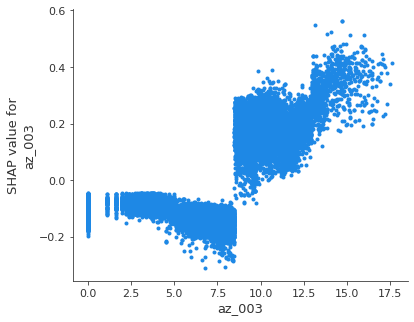

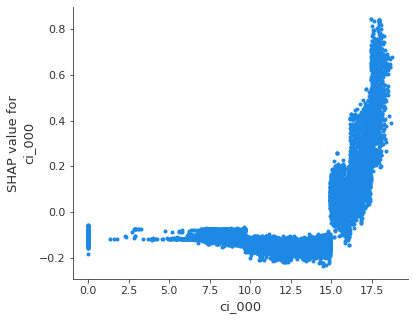

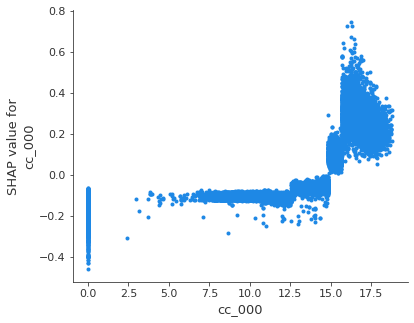

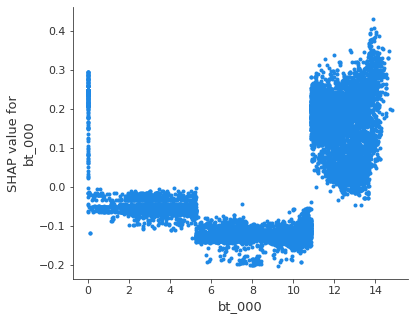

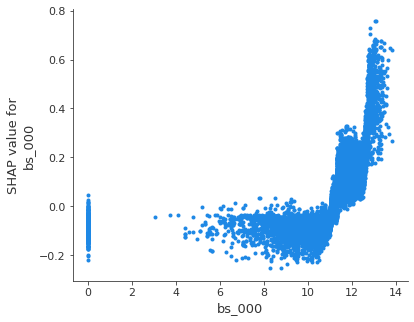

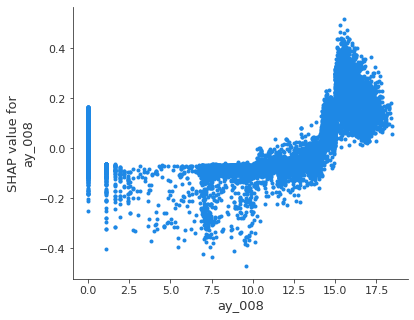

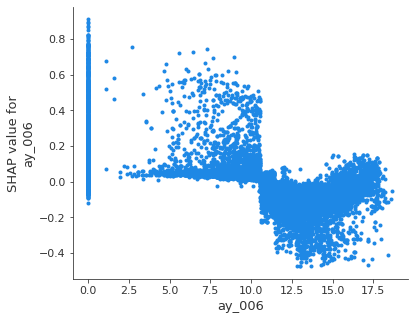

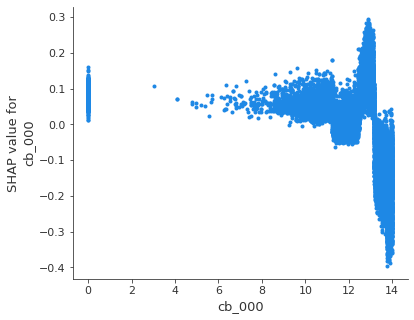

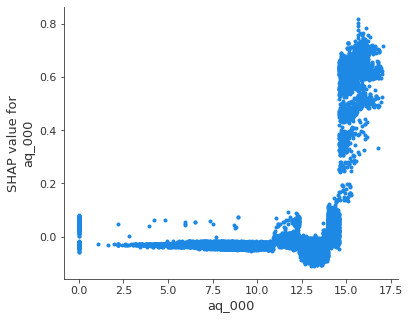

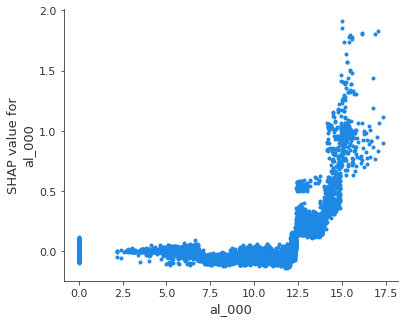

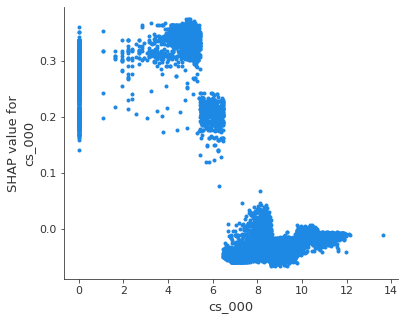

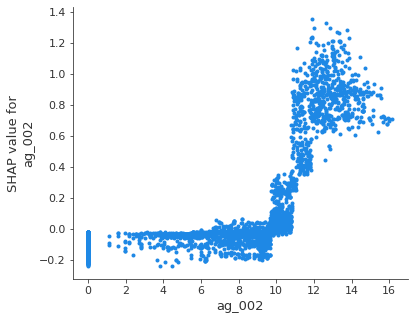

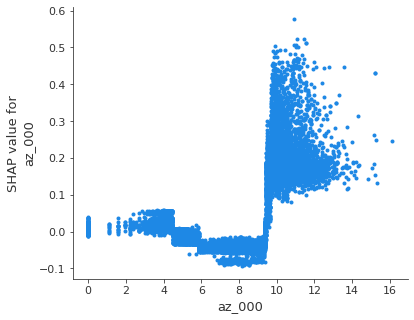

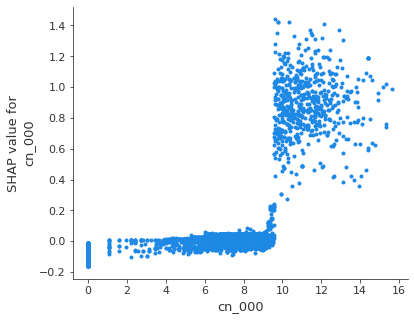

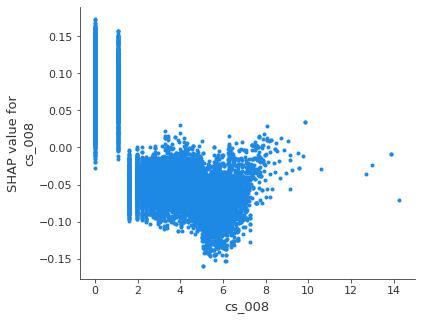

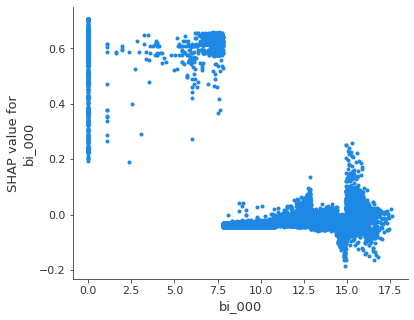

In [33]:
top_feats = ['aa_000','dx_000','ck_000',
             'ai_000','az_003','ci_000',
             'cc_000','bt_000','bs_000',
             'ay_008','ay_006','cb_000',
             'aq_000','al_000','cs_000',
             'ag_002','az_000','cn_000',
             'cs_008','bi_000']
for feat in top_feats:
    shap.dependence_plot(feat, shap_values[1], df_x2, interaction_index=None)

## Modelling Using Less Features

Utilizing less features for the model decreases model complexity therefore making it more interpretable whilst reducing computational complexity. The code below re-runs the testing using only the top features.

In [34]:
validation_sets = [Dataset(df_x2[top_feats].values[val_index[x::3]],
                           label=y_2.values[val_index[x::3]])
                   for x in range(3)]

lgbm_model = lgb.train(params, Dataset(df_x2[top_feats].values[train_index],
                                       label=y_2.values[train_index]),
                       valid_sets=validation_sets)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's auc: 0.948427	valid_1's auc: 0.931487	valid_2's auc: 0.941201
Training until validation scores don't improve for 25 rounds
[2]	valid_0's auc: 0.965926	valid_1's auc: 0.948145	valid_2's auc: 0.953493
[3]	valid_0's auc: 0.971846	valid_1's auc: 0.951343	valid_2's auc: 0.957551
[4]	valid_0's auc: 0.973538	valid_1's auc: 0.954069	valid_2's auc: 0.959228
[5]	valid_0's auc: 0.974961	valid_1's auc: 0.955998	valid_2's auc: 0.960414
[6]	valid_0's auc: 0.975581	valid_1's auc: 0.956082	valid_2's auc: 0.960475
[7]	valid_0's auc: 0.97649	valid_1's auc: 0.95669	valid_2's auc: 0.961163
[8]	valid_0's auc: 0.977008	valid_1's auc: 0.957721	valid_2's auc: 0.961907
[9]	valid_0's auc: 0.977516	valid_1's auc: 0.958479	valid_2's auc: 0.962965
[10]	valid_0's auc: 0.977815	valid_1's auc: 0.958986	valid_2's auc: 0.967354
[11]	valid_0's auc: 0.978486	valid_1's auc: 0.959651	valid_2's auc: 0.968068
[12]	valid_0's auc: 0.978315	valid_1's auc: 0.960268	valid_2's auc: 0.968647
[13]	valid_0's auc: 0.9787

### ROC-AUC

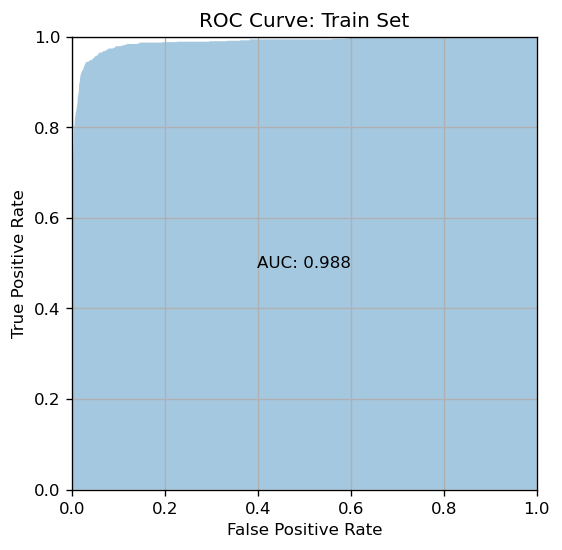

In [37]:
eval_roc_auc(lgbm_model, x_2[top_feats], y_2, 'Train Set')

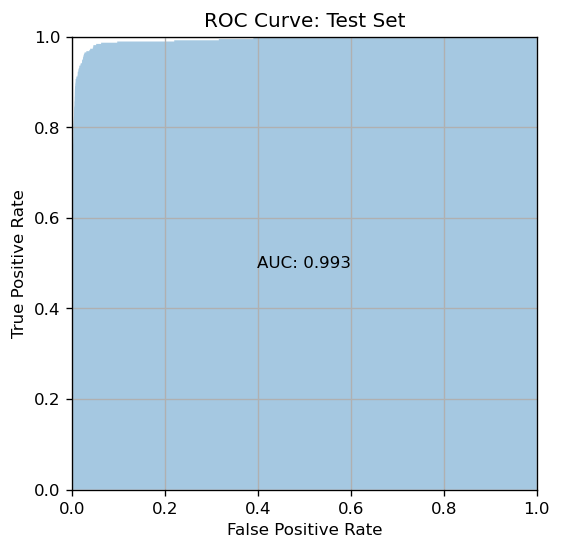

In [44]:
eval_roc_auc(lgbm_model, x_test[top_feats], y_test, 'Test Set')

### PR-F1

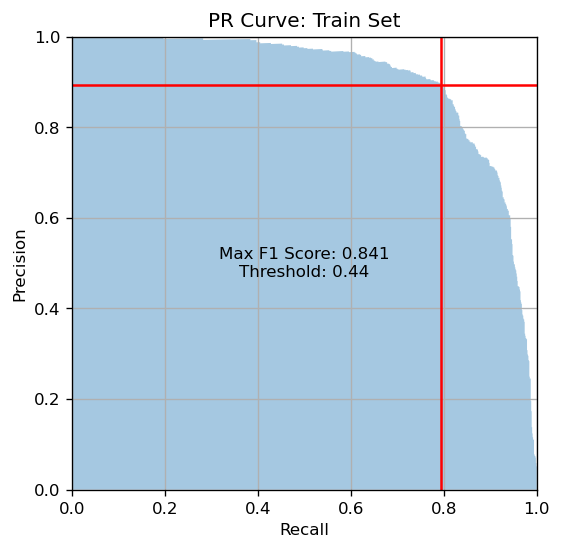

In [46]:
eval_prc(lgbm_model, x_2[top_feats], y_2, 'Train Set')

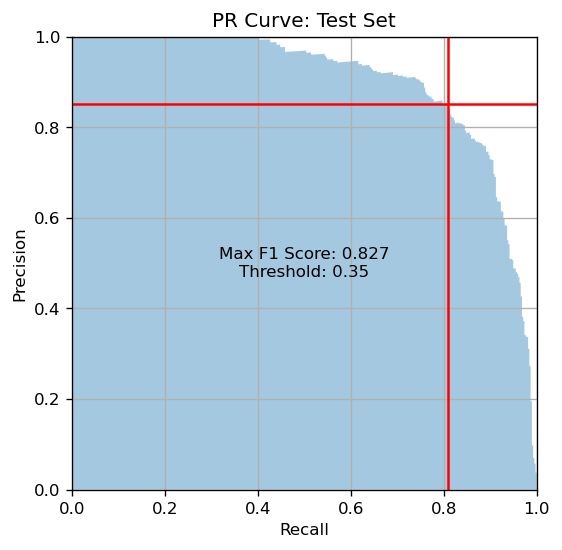

In [47]:
eval_prc(lgbm_model, x_test[top_feats], y_test, 'Test Set')

There seems to be a slight drop in performance, but the model is nonetheless much lighter compared to the initial model that uses all the features. Furthermore, the slight drop in performance is not statistically significant since re-doing the training can sometimes yield better performance (i.e. slight drop in performance may be due to random chance).

## 2nd Modelling Attempt: Drop Outlying Majority Class

We will re-do the modelling phase but this time the outlying majority class will be dropped. The threshold anomaly score will still be 0.413 but this time we are only considering the points that are less than this threshold. The discussion from here on out will not be as detailed since most of the assumptions and explanations have already been covered in the previous sections.

In [48]:
# Remove inlying majority class
df_tmp = pd.DataFrame(anomaly_scores_71,
                      columns=['anomaly_score']).join(pd.DataFrame(y.reset_index(drop=True))
                                                      .join(pd.DataFrame(x)))

x_2_0 = df_tmp[(df_tmp['anomaly_score']<0.413)&(df_tmp['class']==0.0)]
x_2_0 = x_2_0[x_2_0.columns[1:]]
x_2_1 = df_tmp[df_tmp['class']==1.0]
x_2_1 = x_2_1[x_2_1.columns[1:]]

# Append then shuffle the data
data_2 = x_2_0.append(x_2_1).sample(frac=1)
x_2 = data_2[data_2.columns[1:]]
y_2 = data_2['class']

In [49]:
x_test = df_test[df_train.columns[1:]]
# No droping of rows with many null values

x_test = rescale(x_test)

imputer = SimpleImputer(strategy='most_frequent')
x_test = imputer.fit_transform(x_test)

x_test = pd.DataFrame(x_test)
x_test.columns = x_2.columns

# No outlier analysis / inlier removal
y_test = df_test['class']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**In the interest of time the nfold cross validation of the hyperparameter tuning will be reduced to just 5 folds.**

In [50]:
param_grid = {'num_leaves': [70,50,30],
              'min_data_in_leaf': [35,55,75],
              'lambda_l1': [0.00001,0.0001,0.001],
              'lambda_l2': [10,100,1000],
              'bagging_fraction':[0.5],
              'feature_fraction':[0.5],
              'objective':['binary'],'path_smooth':[3],
              'max_depth':[10], 'max_bin':[150],
              'min_gain_to_split':[0.2],
              'learning_rate':[0.1]}

cv_results = []
for i,hyperparams in enumerate(list(ParameterGrid(param_grid))):
    
    validation_summary = lgb.cv(hyperparams,
                                Dataset(x_2, label=y_2),
                                num_boost_round=1500,
                                nfold=5,
                                metrics=["auc"],
                                early_stopping_rounds=25,
                                verbose_eval=25, seed=42)
    
    # Store the best hyperparameters
    cv_results.append((hyperparams, validation_summary["auc-mean"][-1]))
    
    print(i)

[25]	cv_agg's auc: 0.993829 + 0.00369975
[50]	cv_agg's auc: 0.995332 + 0.00350024
[75]	cv_agg's auc: 0.995799 + 0.00329548
[100]	cv_agg's auc: 0.996401 + 0.00283339
[125]	cv_agg's auc: 0.996598 + 0.00273043
[150]	cv_agg's auc: 0.996717 + 0.0025777
[175]	cv_agg's auc: 0.996923 + 0.00235159
[200]	cv_agg's auc: 0.99693 + 0.0023596
[225]	cv_agg's auc: 0.996945 + 0.00234119
[250]	cv_agg's auc: 0.996964 + 0.00233276
0
[25]	cv_agg's auc: 0.993829 + 0.00369975
[50]	cv_agg's auc: 0.995332 + 0.00350024
[75]	cv_agg's auc: 0.995799 + 0.00329548
[100]	cv_agg's auc: 0.996401 + 0.00283339
[125]	cv_agg's auc: 0.996598 + 0.00273043
[150]	cv_agg's auc: 0.996717 + 0.0025777
[175]	cv_agg's auc: 0.996923 + 0.00235159
[200]	cv_agg's auc: 0.99693 + 0.0023596
[225]	cv_agg's auc: 0.996945 + 0.00234119
[250]	cv_agg's auc: 0.996964 + 0.00233276
1
[25]	cv_agg's auc: 0.993829 + 0.00369975
[50]	cv_agg's auc: 0.995332 + 0.00350024
[75]	cv_agg's auc: 0.995799 + 0.00329548
[100]	cv_agg's auc: 0.996401 + 0.00283339
[12

[75]	cv_agg's auc: 0.99616 + 0.00285686
30
[25]	cv_agg's auc: 0.994139 + 0.00370997
[50]	cv_agg's auc: 0.995937 + 0.00277967
[75]	cv_agg's auc: 0.99616 + 0.00285686
31
[25]	cv_agg's auc: 0.994139 + 0.00370997
[50]	cv_agg's auc: 0.995937 + 0.00277967
[75]	cv_agg's auc: 0.99616 + 0.00285686
32
[25]	cv_agg's auc: 0.995508 + 0.00220428
[50]	cv_agg's auc: 0.996239 + 0.00259396
[75]	cv_agg's auc: 0.996138 + 0.00280084
[100]	cv_agg's auc: 0.996796 + 0.0023561
[125]	cv_agg's auc: 0.996876 + 0.00238109
[150]	cv_agg's auc: 0.997069 + 0.00224232
[175]	cv_agg's auc: 0.997129 + 0.00216556
[200]	cv_agg's auc: 0.9972 + 0.00212779
[225]	cv_agg's auc: 0.997241 + 0.00209777
[250]	cv_agg's auc: 0.99725 + 0.0020934
33
[25]	cv_agg's auc: 0.995508 + 0.00220428
[50]	cv_agg's auc: 0.996239 + 0.00259396
[75]	cv_agg's auc: 0.996138 + 0.00280084
[100]	cv_agg's auc: 0.996796 + 0.0023561
[125]	cv_agg's auc: 0.996876 + 0.00238109
[150]	cv_agg's auc: 0.997069 + 0.00224232
[175]	cv_agg's auc: 0.997129 + 0.00216556
[2

[75]	cv_agg's auc: 0.995244 + 0.00283985
[100]	cv_agg's auc: 0.995649 + 0.0024517
[125]	cv_agg's auc: 0.995558 + 0.00249619
67
[25]	cv_agg's auc: 0.992874 + 0.00409843
[50]	cv_agg's auc: 0.995124 + 0.00288927
[75]	cv_agg's auc: 0.995244 + 0.00283985
[100]	cv_agg's auc: 0.995649 + 0.0024517
[125]	cv_agg's auc: 0.995558 + 0.00249619
68
[25]	cv_agg's auc: 0.993113 + 0.00391626
[50]	cv_agg's auc: 0.995389 + 0.00316766
[75]	cv_agg's auc: 0.99594 + 0.00241157
69
[25]	cv_agg's auc: 0.993113 + 0.00391626
[50]	cv_agg's auc: 0.995389 + 0.00316766
[75]	cv_agg's auc: 0.99594 + 0.00241157
70
[25]	cv_agg's auc: 0.993113 + 0.00391626
[50]	cv_agg's auc: 0.995389 + 0.00316766
[75]	cv_agg's auc: 0.99594 + 0.00241157
71
[25]	cv_agg's auc: 0.989694 + 0.00369997
[50]	cv_agg's auc: 0.991254 + 0.00381567
[75]	cv_agg's auc: 0.991651 + 0.00400976
[100]	cv_agg's auc: 0.991881 + 0.00406051
[125]	cv_agg's auc: 0.992272 + 0.00377885
[150]	cv_agg's auc: 0.992544 + 0.00355068
[175]	cv_agg's auc: 0.992335 + 0.003754


In [53]:
params = sorted(cv_results, key=lambda x: x[1], reverse=True)[0][0]
params['metric'] = ["auc"]
params['num_boost_round'] = 1500
params['nfold'] = 10
params['early_stopping_rounds'] = 25
params['verbose_eval'] = 25

# Split Use 3 Validation Sets From Training Set
train_index = random.sample(range(x_2.shape[0]), 10000)
val_index = list(set(range(x_2.shape[0])).difference(train_index))
random.shuffle(val_index)
validation_sets = [Dataset(x_2.values[val_index[x::3]],
                           label=y_2.values[val_index[x::3]])
                   for x in range(3)]

# Model
lgbm_model = lgb.train(params, Dataset(x_2.values[train_index],
                                       label=y_2.values[train_index]),
                       valid_sets=validation_sets)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's auc: 0.980911	valid_1's auc: 0.981942	valid_2's auc: 0.980812
Training until validation scores don't improve for 25 rounds
[2]	valid_0's auc: 0.983251	valid_1's auc: 0.981991	valid_2's auc: 0.987104
[3]	valid_0's auc: 0.98618	valid_1's auc: 0.984665	valid_2's auc: 0.991874
[4]	valid_0's auc: 0.986025	valid_1's auc: 0.984474	valid_2's auc: 0.991717
[5]	valid_0's auc: 0.988203	valid_1's auc: 0.990337	valid_2's auc: 0.993502
[6]	valid_0's auc: 0.988126	valid_1's auc: 0.990067	valid_2's auc: 0.993456
[7]	valid_0's auc: 0.990365	valid_1's auc: 0.990672	valid_2's auc: 0.993519
[8]	valid_0's auc: 0.990477	valid_1's auc: 0.990697	valid_2's auc: 0.993535
[9]	valid_0's auc: 0.990507	valid_1's auc: 0.990745	valid_2's auc: 0.993579
[10]	valid_0's auc: 0.992491	valid_1's auc: 0.990891	valid_2's auc: 0.993681
[11]	valid_0's auc: 0.992367	valid_1's auc: 0.990918	valid_2's auc: 0.993765
[12]	valid_0's auc: 0.99236	valid_1's auc: 0.99085	valid_2's auc: 0.993774
[13]	valid_0's auc: 0.99253

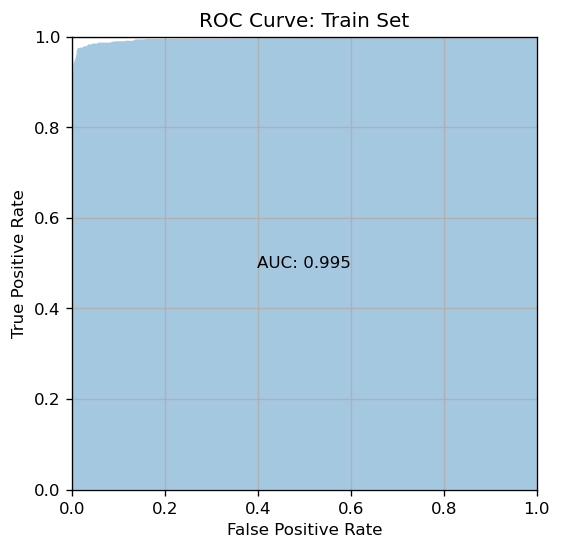

In [54]:
eval_roc_auc(lgbm_model, x_2, y_2, 'Train Set')

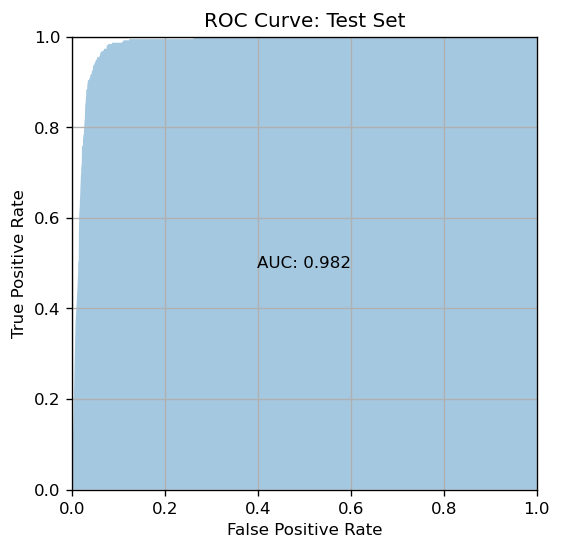

In [55]:
eval_roc_auc(lgbm_model, x_test, y_test, 'Test Set')

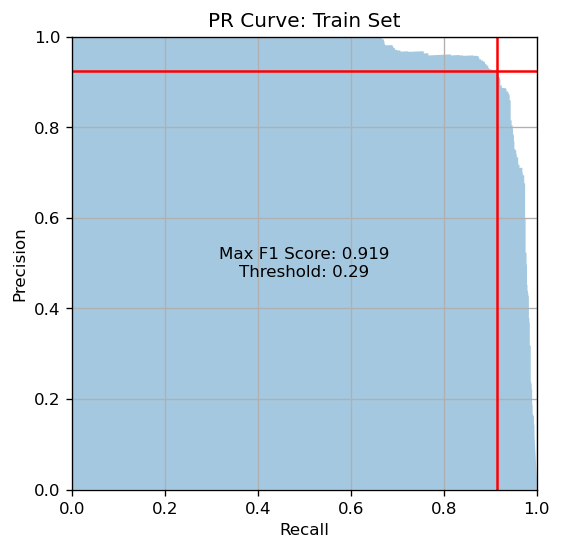

In [56]:
eval_prc(lgbm_model, x_2, y_2, 'Train Set')

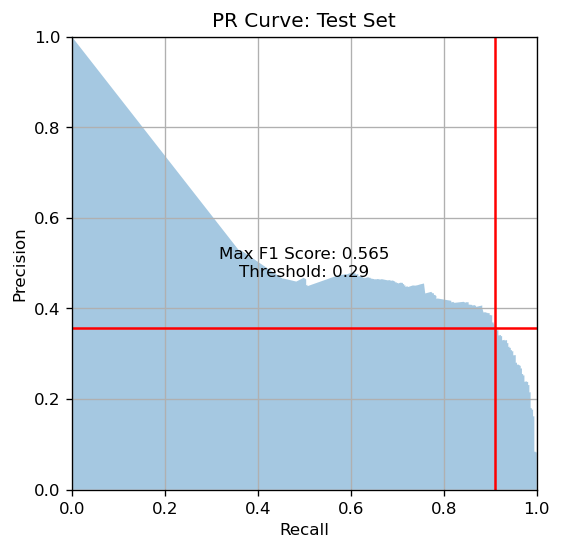

In [58]:
eval_prc(lgbm_model, x_test, y_test, 'Test Set', 29)

**It seems that removing too much of the outlying majority class actually hurts the model's performance!**

In order to verify this observation, the code blow sets the threshold to a much higher value of 0.45.

In [59]:
# Remove inlying majority class
df_tmp = pd.DataFrame(anomaly_scores_71,
                      columns=['anomaly_score']).join(pd.DataFrame(y.reset_index(drop=True))
                                                      .join(pd.DataFrame(x)))

x_2_0 = df_tmp[(df_tmp['anomaly_score']<0.45)&(df_tmp['class']==0.0)]
x_2_0 = x_2_0[x_2_0.columns[1:]]
x_2_1 = df_tmp[df_tmp['class']==1.0]
x_2_1 = x_2_1[x_2_1.columns[1:]]

# Append then shuffle the data
data_2 = x_2_0.append(x_2_1).sample(frac=1)
x_2 = data_2[data_2.columns[1:]]
y_2 = data_2['class']

x_test = df_test[df_train.columns[1:]]
# No droping of rows with many null values

x_test = rescale(x_test)

imputer = SimpleImputer(strategy='most_frequent')
x_test = imputer.fit_transform(x_test)

x_test = pd.DataFrame(x_test)
x_test.columns = x_2.columns

# No outlier analysis / inlier removal
y_test = df_test['class']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [60]:
param_grid = {'num_leaves': [70,50,30],
              'min_data_in_leaf': [35,55,75],
              'lambda_l1': [0.00001,0.0001,0.001],
              'lambda_l2': [10,100,1000],
              'bagging_fraction':[0.5],
              'feature_fraction':[0.5],
              'objective':['binary'],'path_smooth':[3],
              'max_depth':[10], 'max_bin':[150],
              'min_gain_to_split':[0.2],
              'learning_rate':[0.1]}

cv_results = []
for i,hyperparams in enumerate(list(ParameterGrid(param_grid))):
    
    validation_summary = lgb.cv(hyperparams,
                                Dataset(x_2, label=y_2),
                                num_boost_round=1500,
                                nfold=5,
                                metrics=["auc"],
                                early_stopping_rounds=25,
                                verbose_eval=25, seed=42)
    
    # Store the best hyperparameters
    cv_results.append((hyperparams, validation_summary["auc-mean"][-1]))
    
    print(i)

[25]	cv_agg's auc: 0.991146 + 0.00389071
[50]	cv_agg's auc: 0.992725 + 0.00306361
[75]	cv_agg's auc: 0.993533 + 0.00231429
0
[25]	cv_agg's auc: 0.991146 + 0.00389071
[50]	cv_agg's auc: 0.992725 + 0.00306361
[75]	cv_agg's auc: 0.993533 + 0.00231429
1
[25]	cv_agg's auc: 0.991169 + 0.00384809
[50]	cv_agg's auc: 0.992862 + 0.00284291
[75]	cv_agg's auc: 0.993256 + 0.0026428
[100]	cv_agg's auc: 0.99332 + 0.00269501
2
[25]	cv_agg's auc: 0.991509 + 0.00288691
[50]	cv_agg's auc: 0.993045 + 0.00302106
[75]	cv_agg's auc: 0.993296 + 0.00298753
[100]	cv_agg's auc: 0.993344 + 0.0026005
[125]	cv_agg's auc: 0.993229 + 0.00270853
3
[25]	cv_agg's auc: 0.991509 + 0.00288691
[50]	cv_agg's auc: 0.993045 + 0.00302106
[75]	cv_agg's auc: 0.993296 + 0.00298753
[100]	cv_agg's auc: 0.993344 + 0.0026005
[125]	cv_agg's auc: 0.993229 + 0.00270853
4
[25]	cv_agg's auc: 0.991578 + 0.00281461
[50]	cv_agg's auc: 0.992858 + 0.0024864
[75]	cv_agg's auc: 0.993527 + 0.0024458
[100]	cv_agg's auc: 0.993703 + 0.00217134
5
[25]

[75]	cv_agg's auc: 0.988627 + 0.00307167
[100]	cv_agg's auc: 0.989407 + 0.0029462
[125]	cv_agg's auc: 0.990099 + 0.00274404
[150]	cv_agg's auc: 0.990083 + 0.00258825
[175]	cv_agg's auc: 0.990599 + 0.00278652
49
[25]	cv_agg's auc: 0.98431 + 0.00440218
[50]	cv_agg's auc: 0.986906 + 0.00391111
[75]	cv_agg's auc: 0.988627 + 0.00307167
[100]	cv_agg's auc: 0.989407 + 0.0029462
[125]	cv_agg's auc: 0.990099 + 0.00274404
[150]	cv_agg's auc: 0.990083 + 0.00258825
[175]	cv_agg's auc: 0.990599 + 0.00278652
50
[25]	cv_agg's auc: 0.984217 + 0.00446106
[50]	cv_agg's auc: 0.986827 + 0.0038929
[75]	cv_agg's auc: 0.988856 + 0.00298842
[100]	cv_agg's auc: 0.989638 + 0.00301263
[125]	cv_agg's auc: 0.990035 + 0.00270047
[150]	cv_agg's auc: 0.989974 + 0.00275372
[175]	cv_agg's auc: 0.990169 + 0.00303947
51
[25]	cv_agg's auc: 0.984217 + 0.00446106
[50]	cv_agg's auc: 0.986827 + 0.0038929
[75]	cv_agg's auc: 0.988856 + 0.00298842
[100]	cv_agg's auc: 0.989638 + 0.00301263
[125]	cv_agg's auc: 0.990035 + 0.0027004

In [61]:
params = sorted(cv_results, key=lambda x: x[1], reverse=True)[0][0]
params['metric'] = ["auc"]
params['num_boost_round'] = 1500
params['nfold'] = 10
params['early_stopping_rounds'] = 25
params['verbose_eval'] = 25

# Split Use 3 Validation Sets From Training Set
train_index = random.sample(range(x_2.shape[0]), 10000)
val_index = list(set(range(x_2.shape[0])).difference(train_index))
random.shuffle(val_index)
validation_sets = [Dataset(x_2.values[val_index[x::3]],
                           label=y_2.values[val_index[x::3]])
                   for x in range(3)]

# Model
lgbm_model = lgb.train(params, Dataset(x_2.values[train_index],
                                       label=y_2.values[train_index]),
                       valid_sets=validation_sets)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's auc: 0.958389	valid_1's auc: 0.968675	valid_2's auc: 0.972061
Training until validation scores don't improve for 25 rounds
[2]	valid_0's auc: 0.969629	valid_1's auc: 0.97049	valid_2's auc: 0.975561
[3]	valid_0's auc: 0.973268	valid_1's auc: 0.976003	valid_2's auc: 0.977092
[4]	valid_0's auc: 0.979419	valid_1's auc: 0.980657	valid_2's auc: 0.984318
[5]	valid_0's auc: 0.979484	valid_1's auc: 0.980812	valid_2's auc: 0.984386
[6]	valid_0's auc: 0.981003	valid_1's auc: 0.980697	valid_2's auc: 0.984299
[7]	valid_0's auc: 0.981311	valid_1's auc: 0.980985	valid_2's auc: 0.98466
[8]	valid_0's auc: 0.985218	valid_1's auc: 0.983207	valid_2's auc: 0.984986
[9]	valid_0's auc: 0.985292	valid_1's auc: 0.983314	valid_2's auc: 0.985117
[10]	valid_0's auc: 0.985587	valid_1's auc: 0.983598	valid_2's auc: 0.98531
[11]	valid_0's auc: 0.985555	valid_1's auc: 0.985352	valid_2's auc: 0.986966
[12]	valid_0's auc: 0.985648	valid_1's auc: 0.98547	valid_2's auc: 0.98708
[13]	valid_0's auc: 0.985811	

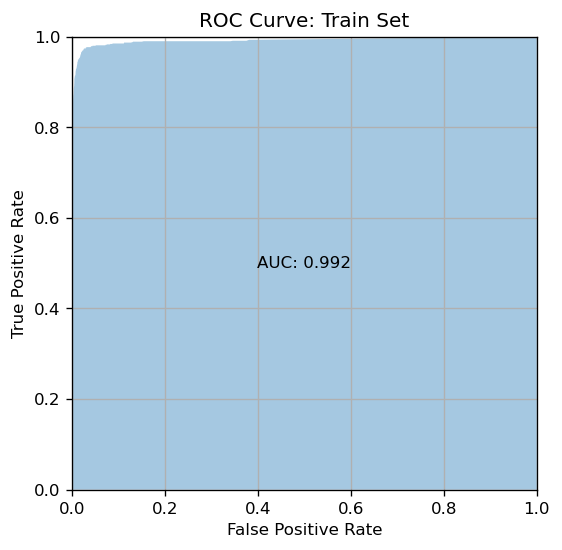

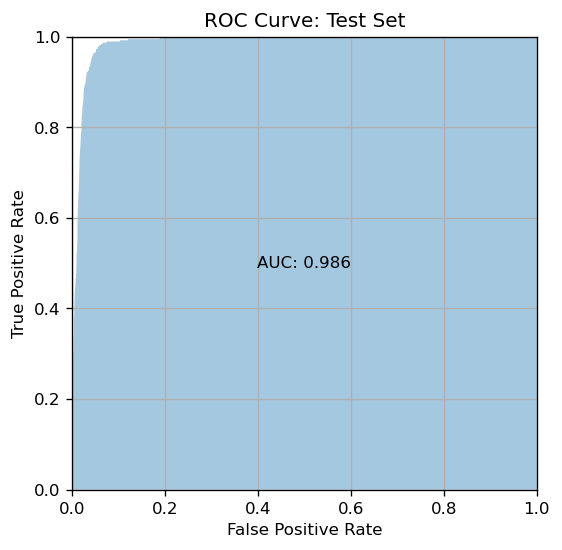

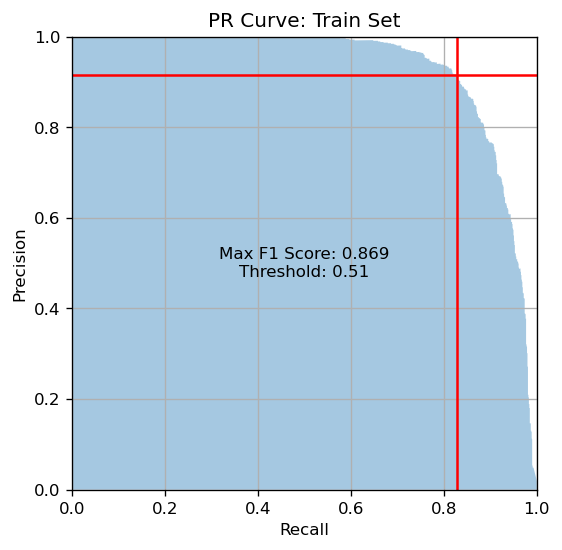

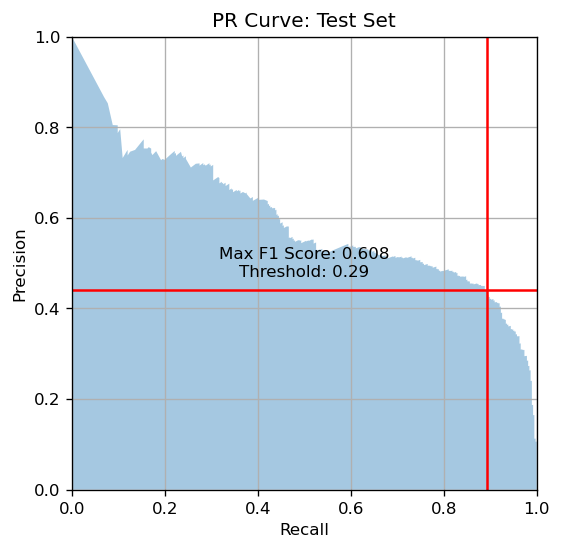

In [62]:
eval_roc_auc(lgbm_model, x_2, y_2, 'Train Set')
eval_roc_auc(lgbm_model, x_test, y_test, 'Test Set')
eval_prc(lgbm_model, x_2, y_2, 'Train Set')
eval_prc(lgbm_model, x_test, y_test, 'Test Set', 29)

Performing classification on the inlying majority class vs outlying minority class hurts the models performance! Feature importance at this point will only yield misleading results.